In [2]:
from termcolor import colored
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

import keras
from keras.layers import Input, Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras import backend
from keras.models import load_model
from keras.layers import Dropout, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### The following presentation will demonstrate the use of two ML approaches for solving a classification problem.

### The first model is a simple fully connected logistic regression model.

### The second model is one I'm particularly excited about, the Generative Adversarial Network (GAN).

### GAN's are constructed by pitting two networks against each other in a zero sum game.  The Discriminator is trained to detect fake loan applications and labels whether an application is likely to be approved or rejected.  The Generator is then fed noise to produce fake loan applications to the Discriminator with the objective of passing as a valid loan.  As the Discriminator learns to detect fake applications it forces the Generator to learn more clever ways to pass a fake.  Essentially, the Generator will learn the fundamental distribution of the dataset.  Over time, each network reinforces the others weights to achieve an optimal equilibrium.

### It is worth noting that GAN's have been successful in several areas including datasets with limited labelled data and image generation.

### Let's start by downloading and loading all HMDA data filtered by state of Connecticut for 2014-2016 limited to those intended for home purchase.

In [3]:
# Note: link to data and filter settings
# Note: https://www.consumerfinance.gov/data-research/hmda/explore#!/as_of_year=2016,2015,2014&state_code-1=9&loan_purpose=1&section=filters

data = pd.read_csv('/home/shant/Downloads/hmda/hmda_lar.csv',low_memory=False,header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171251 entries, 0 to 171250
Data columns (total 78 columns):
action_taken                      171251 non-null int64
action_taken_name                 171251 non-null object
agency_code                       171251 non-null int64
agency_abbr                       171251 non-null object
agency_name                       171251 non-null object
applicant_ethnicity               171251 non-null int64
applicant_ethnicity_name          171251 non-null object
applicant_income_000s             148174 non-null float64
applicant_race_1                  171251 non-null int64
applicant_race_2                  648 non-null float64
applicant_race_3                  36 non-null float64
applicant_race_4                  8 non-null float64
applicant_race_5                  9 non-null float64
applicant_race_name_1             171251 non-null object
applicant_race_name_2             648 non-null object
applicant_race_name_3             36 non-null object


### At first glance we notice that most of the data has a scalar value and an associated label denoted by column names ending with "_name".

### There are several fields indicating the reason for denying the application.  We will exclude these features since that information is relevant after the target value has been determined.

### Respondent ID stands out as valuable information related to the mortgage issuer.  Let's convert these text columns to scalar values by using pandas factorize method.

### Let's remove all the redundant name data and define our features.

### Let's also look at the dataframe description to see if we should pre-normalize the data or use Batch Normalization instead.

In [4]:
data['issuer'] = data[['respondent_id']].apply(lambda col: pd.factorize(col)[0])

features = [
    'agency_code','applicant_ethnicity','applicant_income_000s','applicant_race_1','applicant_race_2','applicant_race_3',
    'applicant_race_4','applicant_race_5','applicant_sex','application_date_indicator','as_of_year','census_tract_number',
    'co_applicant_ethnicity','co_applicant_race_1','co_applicant_race_2','co_applicant_race_3','co_applicant_race_4',
    'co_applicant_race_5','co_applicant_sex','county_code',
    'edit_status',
    'hoepa_status','hud_median_family_income','lien_status','loan_amount_000s','loan_purpose','loan_type','minority_population',
    'msamd','number_of_1_to_4_family_units','number_of_owner_occupied_units','owner_occupancy','population','preapproval',
    'property_type','purchaser_type','rate_spread',
    'issuer',
    'sequence_number','state_code','tract_to_msamd_income']


### Next, let's explore the different values associated with actions_taken in the distribution and define our target Y.  There are 8 unique responses in the dataset.  Since we are only interested in predicting which applications will be approved let's consolidate the 8 values into 0 for denial, 1 for approval.  

### For the purposes of this exercise we will assume that the following actions will be considered an approval:
    1: Loan originated

### We will assume the following actions will be considered denial:
	3: Application denied by financial institution

### We will drop all other actions since it is not explicit with respect to the objective function.

	

In [5]:
for k,v in data.groupby(['action_taken','action_taken_name']):
    print(k,":\t Count:",len(v))
data = data[data.action_taken.isin([1,3])]
data['approved'] = data.action_taken.isin([1]).astype(int)
data = data.fillna(0)

print("")
print("Y values:")
for k,v in data.groupby(['approved','action_taken_name']):
    print(k,":\t Count:",len(v))

(1, 'Loan originated') :	 Count: 99210
(2, 'Application approved but not accepted') :	 Count: 4061
(3, 'Application denied by financial institution') :	 Count: 14220
(4, 'Application withdrawn by applicant') :	 Count: 15604
(5, 'File closed for incompleteness') :	 Count: 3451
(6, 'Loan purchased by the institution') :	 Count: 34696
(7, 'Preapproval request denied by financial institution') :	 Count: 4
(8, 'Preapproval request approved but not accepted') :	 Count: 5

Y values:
(0, 'Application denied by financial institution') :	 Count: 14220
(1, 'Loan originated') :	 Count: 99210


### Let's explore the feature description

In [179]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print("---- Min ----")
print(data[features].min())
print("---- Max ----")
print(data[features].max())
print(data.T.apply(lambda x: x.nunique(),axis=1))
# print(data[features].describe())

---- Min ----
agency_code                         1.000
applicant_ethnicity                 1.000
applicant_income_000s               0.000
applicant_race_1                    1.000
applicant_race_2                    0.000
applicant_race_3                    0.000
applicant_race_4                    0.000
applicant_race_5                    0.000
applicant_sex                       1.000
application_date_indicator          0.000
as_of_year                       2014.000
census_tract_number                 0.000
co_applicant_ethnicity              1.000
co_applicant_race_1                 1.000
co_applicant_race_2                 0.000
co_applicant_race_3                 0.000
co_applicant_race_4                 0.000
co_applicant_race_5                 0.000
co_applicant_sex                    1.000
county_code                         0.000
edit_status                         0.000
hoepa_status                        1.000
hud_median_family_income            0.000
lien_status         

### The following code blocks are intended to be executed during/after training to evaluate performance.  We will load the saved test results from disk and compute basic statistics.

### Let's analyze the results!

In [9]:
def analyze(filename):
    results = pd.read_csv('/home/shant/PycharmProjects/OWL/'+filename,low_memory=False)
    mislabeled = results[results.approved != results.prediction]
    total = len(results)
    error = len(mislabeled)/total
    accuracy = 1 - error
    denied = results.loc[results.approved==0,'approved'].count()
    approved = results.loc[results.approved==1,'approved'].count()
    denied_tp = results.loc[(results.approved==0)&(results.prediction==0),'prediction'].count()
    approved_tp = results.loc[(results.approved==1)&(results.prediction==1),'prediction'].count()
    roc_prob = roc_auc_score(results.approved, results.probs)
    roc_pred = roc_auc_score(results.approved, results.prediction)
    fpr,tpr,thresh = roc_curve(results.approved,results.probs)
    fpr_pred,tpr_pred,thresh_pred = roc_curve(results.approved,results.prediction)
    roc_auc = auc(fpr,tpr)
    roc_auc_pred = auc(fpr_pred,tpr_pred)
    print("Accuracy:             \t {:0.2f}% / {:0.2f}%".format(accuracy * 100,error*100))
#     print("Accuracy:           \t {:0.2f}%".format(accuracy*100))
#     print("Denied              \t",denied)
#     print("Approved            \t",approved)
    print("Denied True Pos     \t {} / {:0.2f}%".format(denied_tp,100*(denied_tp/denied)))
    print("Approved True Pos   \t {} / {:0.2f}%".format(approved_tp,100*(approved_tp/approved)))
#     print("AUC Predictions     \t {:0.2f}".format())
#     print("--")
    print("True/False Positives\t {:0.2f} / {:0.2f}".format(tpr_pred[1]*100,fpr_pred[1]*100))
    print("AUC Preds/Probs     \t {:0.2f} / {:0.2f}".format(roc_pred*100,roc_prob*100))
#     print("True positives      \t {:0.2f}".format())
    plt.plot(fpr,tpr,label='ROC Prob Curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr_pred,tpr_pred,label='ROC Prediction Curve (area = %0.2f)' % roc_auc_pred)
    plt.plot([0, 1], [0, 1],lw=2, linestyle='--')
    plt.legend()
    

### First, the simple logistic regression model

Accuracy:             	 87.16% / 12.84%
Denied True Pos     	 2619 / 93.94%
Approved True Pos   	 17155 / 86.21%
True/False Positives	 86.21 / 6.06
AUC Preds/Probs     	 90.08 / 96.33
--------
Accuracy:             	 86.78% / 13.22%
Denied True Pos     	 2623 / 94.08%
Approved True Pos   	 17064 / 85.76%
True/False Positives	 85.76 / 5.92
AUC Preds/Probs     	 89.92 / 96.13


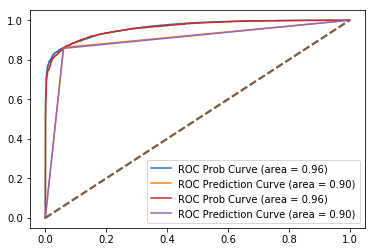

In [263]:
analyze('results_best.txt')
print("--------")
analyze('results.txt')

### Let's do the same analysis for the GAN

Accuracy:             	 93.78% / 6.22%
Denied True Pos     	 2133 / 76.51%
Approved True Pos   	 19141 / 96.20%
True/False Positives	 96.20 / 23.49
AUC Preds/Probs     	 86.35 / 97.09
--------
Accuracy:             	 93.42% / 6.58%
Denied True Pos     	 1945 / 69.76%
Approved True Pos   	 19249 / 96.74%
True/False Positives	 96.74 / 30.24
AUC Preds/Probs     	 83.25 / 96.24


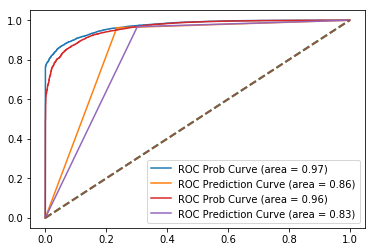

In [329]:
analyze('results_gan_best.txt')
print("--------")
analyze('results_gan.txt')

Accuracy:             	 92.48% / 7.52%
Denied True Pos     	 2277 / 81.67%
Approved True Pos   	 18704 / 94.00%
True/False Positives	 94.00 / 18.33
AUC Preds/Probs     	 87.84 / 96.63


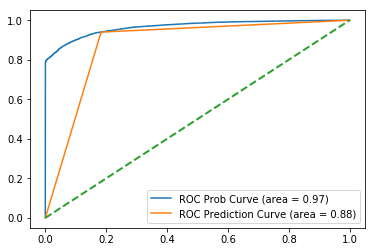

In [264]:
analyze('results_gan_exp_best.txt')
# print("-------")
# analyze('results_gan_exp.txt') # USES 0.5 as discriminator label

Accuracy:             	 86.63% / 13.37%
Denied True Pos     	 2255 / 80.88%
Approved True Pos   	 17398 / 87.44%
True/False Positives	 87.44 / 19.12
AUC Preds/Probs     	 84.16 / 92.15
--------
Accuracy:             	 86.63% / 13.37%
Denied True Pos     	 2255 / 80.88%
Approved True Pos   	 17398 / 87.44%
True/False Positives	 87.44 / 19.12
AUC Preds/Probs     	 84.16 / 92.15


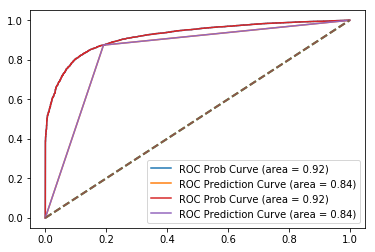

In [261]:
analyze('results_gan_exp_best_v2.txt')
print("--------")
analyze('results_gan_exp_v2.txt') # USES 0.0 as discriminator label


## The GAN stands out in this exercise for several reason.
    AUC and accuracy are far more stable during training than the logistic regression
    While GAN's can be difficult/time consuming to train, it surpasses the logistic regression from the start

